# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from google.colab import drive
drive.mount('/content/drive')
%matplotlib inline

SEED = 3

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the data
azdias = pd.read_csv('/content/drive/My Drive/DATA_SCIENCE/MLEngineer_Nanodegree/data/Udacity_AZDIAS_052018.csv', sep=';') # 682mb
customers = pd.read_csv('/content/drive/My Drive/DATA_SCIENCE/MLEngineer_Nanodegree/data/Udacity_CUSTOMERS_052018.csv', sep=';') # 144mb

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
print(azdias.shape)
print(customers.shape)

(891221, 366)
(191652, 369)


In [4]:
# Check the extra features for customers dataframe:
extra_cols_in_customers = [col for col in customers.columns if col not in azdias.columns]
print("Extra columns in Customers Data: ", extra_cols_in_customers)

Extra columns in Customers Data:  ['PRODUCT_GROUP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE']


In [ ]:
azdias.head()

In [ ]:
# Basic descriptive statistics of azdias:
azdias.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,...,REGIOTYP,RELAT_AB,RETOURTYP_BK_S,RT_KEIN_ANREIZ,RT_SCHNAEPPCHEN,RT_UEBERGROESSE,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,SOHO_KZ,STRUKTURTYP,TITEL_KZ,UMFELD_ALT,UMFELD_JUNG,UNGLEICHENN_FLAG,VERDICHTUNGSRAUM,VERS_TYP,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,8.912210e+05,891221.000000,817722.000000,817722.000000,81058.000000,29499.000000,6170.000000,1205.000000,628274.000000,798073.000000,794213.000000,817722.000000,817722.000000,798073.000000,817722.000000,794005.000000,797481.000000,886367.000000,886367.000000,886367.000000,886367.000000,886367.000000,886367.000000,886367.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,634108.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,770025.000000,794005.00000,886367.000000,886367.000000,886367.000000,839995.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,817722.000000,793947.000000,817722.000000,793435.000000,793435.000000,817722.000000,793947.00000,891221.000000,817722.00000,770025.000000,815304.000000,815304.000000,815304.000000,783619.000000,817722.000000,798073.000000,891221.000000,891221.000000,891221.000000
mean,6.372630e+05,-0.358435,4.421928,10.864126,11.745392,13.402658,14.476013,15.089627,13.700717,8.287263,0.040647,0.154018,1.727637,7.599356,0.004162,3.167854,4.153043,3.632838,3.335264,3.368086,3.195014,3.351290,3.336151,3.360684,3.465980,0.122336,0.219907,9.267420,0.892735,0.568580,0.106769,9.926794,9.439073,0.705221,0.425645,0.467869,1.145516,0.485508,0.257938,1.585405,...,4.257967,3.07222,3.419630,3.233723,3.863797,3.023813,4.667550,4.481405,4.272729,4.445007,4.763223,4.025014,4.359086,4.001597,4.256076,3.910139,4.240609,3.945860,3.661784,4.023709,1.266967,0.008423,2.539212,0.003483,3.223125,4.017526,0.090067,4.58576,1.197852,0.43882,2.417322,6.001214,7.532130,5.945972,3.933406,7.908791,4.052836,3.362438,1.522098,2.777398
std,2.572735e+05,1.198724,3.638805,7.639683,4.097660,3.243300,2.712427,2.452932,5.079849,15.628087,0.324028,0.502389,1.155849,14.332201,0.068855,1.002376,2.183710,1.595021,1.493633,1.368331,1.401382,1.396508,1.373077,1.378992,1.328456,0.535950,0.747903,1.735725,2.011838,1.643764,0.808179,0.605641,1.547773,2.552707,1.510782,1.542151,2.266999,1.639340,1.252328,2.547925,...,2.030385,1.36298,1.417741,1.388687,1.282747,1.502725,1.795712,1.807552,1.915885,1.852412,1.830789,1.903816,2.022829,1.857540,1.770137,1.580306,2.007373,1.946564,1.707637,2.077746,1.287435,0.091392,0.754926,0.084957,1.255785,1.118399,0.286278,8.47152,0.952532,1.14329,1.166572,2.856091,3.247789,2.771464,1.964701,1.923137,1.949539,1.352704,0.499512,1.068775
min,1.916530e+05,-1.000000,1.000000,0.000000,2.000000,2.000000,4.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00

#### Data Preprocessing *azdias* and *customers*

In [ ]:
# Check the number of missing values per column
# There are many columns with missing values:
azdias.isnull().sum()[azdias.isnull().sum() != 0]

In [5]:
# Convert all int64 columns to float64 type since it leads to some problems
# later on imputer
df_list = [azdias, customers]
for data in df_list:
  for col in data.columns:
      if data[col].dtype == np.int64:
          data[col] = data[col].astype(np.float64)

### Load the attribute sheet, with information per column/feature. Prepare it to process the missing values.


In [6]:
feat_info = pd.read_excel('/content/drive/My Drive/DATA_SCIENCE/MLEngineer_Nanodegree/data/DIAS Attributes - Values 2017.xlsx',
                          header = 1)
feat_info.drop(['Unnamed: 0'], axis=1, inplace=True)
feat_info.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,0,no classification possible
2,NaN,NaN,1,passive elderly
3,NaN,NaN,2,cultural elderly
4,NaN,NaN,3,experience-driven elderly


In [7]:
# The feature name only appears in the first row, so we need to fill
# the NAs with forward fill and redefine it as an Attribute column
feat_info_attribute = feat_info['Attribute'].fillna(method='ffill')
feat_info['Attribute'] = feat_info_attribute

In [8]:
# Select the unknown/no values
feat_info_unknown = feat_info[(feat_info['Meaning'].str.contains('unknown') | feat_info['Meaning'].str.contains('no '))]

In [9]:
feat_info_unknown.loc[feat_info['Attribute'] == 'AGER_TYP', 'Value'].astype(str).str.cat(sep=',').split(',')

['-1', '0']

In [10]:
# Combine all missing values for each feature in one row,
# instead of few as it is now for some features
unknown_val = []
for attribute in feat_info_unknown['Attribute'].unique():
    val = feat_info_unknown.loc[feat_info['Attribute'] == attribute, 
                                'Value'].astype(str).str.cat(sep=',').split(',')
    unknown_val.append(val)
feat_info_unknown = pd.concat([pd.Series(feat_info_unknown['Attribute'].unique()), pd.Series(unknown_val)], axis=1)
feat_info_unknown.head()

,0,1
0,AGER_TYP,"[-1, 0]"
1,ALTERSKATEGORIE_GROB,"[-1, 0]"
2,ALTER_HH,[0]
3,ANREDE_KZ,"[-1, 0]"
4,BALLRAUM,[-1]


In [11]:
feat_info_unknown.columns = ['attribute', 'missing_or_unknown']

In [12]:
def missing_to_nan(df1, df2):
  """ Convert the missing/unknown values into NaN """
  for row in df2['attribute']:
      if row in df1.columns:
          na_map = df2.loc[df2['attribute'] == row, 'missing_or_unknown'].iloc[0]
          na_idx = df1.loc[:, row].isin(na_map)
          df1.loc[na_idx, row] = np.nan
      else:
          continue
  return df1

In [13]:
azdias = missing_to_nan(azdias, feat_info_unknown)
customers = missing_to_nan(customers, feat_info_unknown)

### Investigate the NaN amount:

In [14]:
count_nan_azdias = (azdias.isnull().sum()/len(azdias))*100
count_nan_customers = (customers.isnull().sum()/len(customers))*100

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


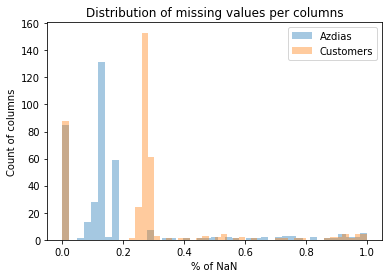

In [ ]:
plt.figure()
sns.distplot(count_nan_azdias.values, kde=False, label='Azdias')
sns.distplot(count_nan_customers.values, kde=False, label='Customers')
plt.ylabel('Count of columns')
plt.xlabel('% of NaN')
plt.title('Distribution of missing values per columns')
plt.legend()
plt.show()

In [18]:
# We will drop the columns where more than 30% of rows are missing
# We take as reference the df with larger number of columns

drop_cols_azdias = count_nan_azdias[count_nan_azdias > 30]
drop_cols_customers = count_nan_customers[count_nan_customers > 30]

if len(drop_cols_azdias) > len(drop_cols_customers):
  remove_cols = drop_cols_azdias.index.tolist()
else:
  remove_cols = drop_cols_customers.index.tolist()

azdias = azdias.drop(remove_cols, axis=1)
customers = customers.drop(remove_cols, axis=1)

In [26]:
remove_cols

['AGER_TYP',
 'ALTER_HH',
 'ALTER_KIND1',
 'ALTER_KIND2',
 'ALTER_KIND3',
 'ALTER_KIND4',
 'D19_BANKEN_ANZ_12',
 'D19_BANKEN_ANZ_24',
 'D19_BANKEN_DATUM',
 'D19_BANKEN_OFFLINE_DATUM',
 'D19_BANKEN_ONLINE_DATUM',
 'D19_BANKEN_ONLINE_QUOTE_12',
 'D19_GESAMT_ANZ_12',
 'D19_GESAMT_ANZ_24',
 'D19_GESAMT_DATUM',
 'D19_GESAMT_OFFLINE_DATUM',
 'D19_GESAMT_ONLINE_DATUM',
 'D19_GESAMT_ONLINE_QUOTE_12',
 'D19_TELKO_ANZ_12',
 'D19_TELKO_ANZ_24',
 'D19_TELKO_DATUM',
 'D19_TELKO_OFFLINE_DATUM',
 'D19_TELKO_ONLINE_DATUM',
 'D19_VERSAND_ANZ_12',
 'D19_VERSAND_ANZ_24',
 'D19_VERSAND_DATUM',
 'D19_VERSAND_OFFLINE_DATUM',
 'D19_VERSAND_ONLINE_DATUM',
 'D19_VERSAND_ONLINE_QUOTE_12',
 'D19_VERSI_ANZ_12',
 'D19_VERSI_ANZ_24',
 'EXTSEL992',
 'KBA05_ANTG1',
 'KBA05_ANTG2',
 'KBA05_ANTG3',
 'KBA05_ANTG4',
 'KBA05_BAUMAX',
 'KBA05_MAXVORB',
 'KK_KUNDENTYP',
 'KKK',
 'REGIOTYP',
 'TITEL_KZ']

In [ ]:
# Visualize the total number of missing values per column
#count_list = []
#nan_list = []
#for column in azdias.columns:
#    nan_count = azdias[column].isnull().sum()
#    count_list.append(nan_count)
#    nan_list.append((column, nan_count))

#nan_data = pd.DataFrame(nan_list, columns=['Column', 'Count'])
#nan_data.sort_values('Count', inplace=True, ascending=False)
#nan_data.head()

In [ ]:
print(azdias.shape, customers.shape)

(891221, 324) (191652, 327)


### Now we will focus on the remaining features. For that, we will look at the missing values per row.

Most of the rows have less than 50 missing features, so that could be our limit.

In [ ]:
miss_row_azdias = azdias.isnull().sum(axis=1)
miss_row_customers = customers.isnull().sum(axis=1)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


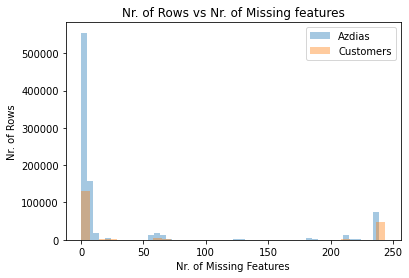

In [ ]:
plt.figure()
plt.title('Nr. of Rows vs Nr. of Missing features')
sns.distplot(miss_row_azdias, kde=False, label='Azdias')
sns.distplot(miss_row_customers, kde=False, label='Customers')
plt.xlabel('Nr. of Missing Features')
plt.ylabel('Nr. of Rows')
plt.legend()
plt.show()

In [ ]:
# Remove rows with more than 50 missing features
azdias = azdias[miss_row_azdias < 50].reset_index(drop=True)
customers = customers[miss_row_customers < 50].reset_index(drop=True)

### Data type

We converted int64 to float64 in the beginning, but we have also *object* data type.

In [ ]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134246 entries, 0 to 134245
Columns: 327 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(319), object(8)
memory usage: 334.9+ MB


In [ ]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 737288 entries, 0 to 737287
Columns: 324 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(318), object(6)
memory usage: 1.8+ GB


In [ ]:
azdias_object_cols = azdias.columns[azdias.dtypes == 'object']
customer_object_cols = customers.columns[customers.dtypes == 'object']

In [ ]:
print(azdias_object_cols, customer_object_cols)

Index(['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015',
       'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'OST_WEST_KZ'],
      dtype='object') Index(['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015',
       'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'OST_WEST_KZ',
       'PRODUCT_GROUP', 'CUSTOMER_GROUP'],
      dtype='object')


In [ ]:
# Investigate further the columns with object data type
for col in azdias_object_cols:
    print('\nColumn ',col)
    print(azdias[col].value_counts())


Column  CAMEO_DEU_2015
6B    54006
8A    50776
4C    43988
2D    32906
7A    32630
3C    32565
3D    32176
8B    31262
4A    30254
8C    30147
9D    26746
9B    25888
7B    22921
9C    22919
9A    20057
2C    17742
8D    16675
6E    15598
5D    14071
2B    14042
6C    13868
2A    11921
1D    11457
1A    10167
5A     9721
5B     9691
5C     9050
4B     8284
7C     8127
4D     8051
6A     6416
3A     5871
6D     5756
3B     5709
6F     5048
4E     5005
1E     4783
7D     4431
7E     4375
1C     4012
5F     3939
9E     3841
1B     3815
5E     3241
XX      284
Name: CAMEO_DEU_2015, dtype: int64

Column  CAMEO_DEUG_2015
8      74754
6      58203
9      57473
4      55290
8.0    54106
2      44419
3      44192
6.0    42489
9.0    41978
7      41861
4.0    40292
2.0    32192
3.0    32129
7.0    30623
5      28976
5.0    20737
1      19840
1.0    14394
X        284
Name: CAMEO_DEUG_2015, dtype: int64

Column  CAMEO_INTL_2015
51      73261
51.0    53068
41      50263
24      49091
41.0    3655

* EINGEFUEGT_AM is not the attributes table, so we drop it.
* CAMEO_DEU_2015, CAMEO_INTL_2015, D19_LETZTER_KAUF_BRANCHE have a large cardinality, which will introduce more noise in the modelling part, so we drop them.
* We encode OST_WEST_KZ.
* For CAMEO_DEUG_2015, there are X values, which haven't been defined in the attributes table, so we will replace it by NaN.

In [ ]:
# Drop EINGEFUEGT_AM, CAMEO_DEU_2015, CAMEO_INTL_2015:
remove_cols2 = ['EINGEFUEGT_AM', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015', 'D19_LETZTER_KAUF_BRANCHE']
azdias = azdias.drop(remove_cols2, axis=1)
customers = customers.drop(remove_cols2, axis=1)

In [ ]:
# Encode OST_WEST_KZ
azdias['OST_WEST_KZ'] = azdias['OST_WEST_KZ'].replace({'W': 0, 'O': 1})
customers['OST_WEST_KZ'] = customers['OST_WEST_KZ'].replace({'W': 0, 'O': 1})

In [ ]:
# Replace X by NaN in CAMEO_DEUG_2015:
azdias['CAMEO_DEUG_2015'] = azdias['CAMEO_DEUG_2015'].replace({'X': np.nan}).astype(float)
customers['CAMEO_DEUG_2015'] = customers['CAMEO_DEUG_2015'].replace({'X': np.nan}).astype(float)

In [2]:
# Checkpoint ~~
#azdias.to_csv('/content/drive/My Drive/DATA_SCIENCE/MLEngineer_Nanodegree/data/azdias_18.csv', header=True)
#customers.to_csv('/content/drive/My Drive/DATA_SCIENCE/MLEngineer_Nanodegree/data/customers_18.csv', header=True)
#azdias = pd.read_csv('/content/drive/My Drive/DATA_SCIENCE/MLEngineer_Nanodegree/data/azdias_18.csv')
#customers = pd.read_csv('/content/drive/My Drive/DATA_SCIENCE/MLEngineer_Nanodegree/data/customers_18.csv')

### Imput the missing values

We will substitute the missing values by the most common values for each feature, as it makes sense for population data. Another good option would be to substitute by the median.

For the next steps to work properly, we need to remove the three additional columns from customers (defined previously as *extra_cols_in_customers*):

In [3]:
# Extra features for customers dataframe:
extra_cols_in_customers = [col for col in customers.columns if col not in azdias.columns]

In [4]:
customer_extra_cols = customers[extra_cols_in_customers]
customers = customers.drop(extra_cols_in_customers, axis = 1)

In [5]:
imputer = SimpleImputer(strategy='most_frequent')

In [6]:
azdias = pd.DataFrame(imputer.fit_transform(azdias), columns = azdias.columns)
customers = pd.DataFrame(imputer.transform(customers), columns = customers.columns)

In [ ]:
# We can see that missing values have disappeared:
azdias.isnull().sum()

Unnamed: 0              0
LNR                     0
AKT_DAT_KL              0
ALTERSKATEGORIE_FEIN    0
ANZ_HAUSHALTE_AKTIV     0
                       ..
WOHNDAUER_2008          0
WOHNLAGE                0
ZABEOTYP                0
ANREDE_KZ               0
ALTERSKATEGORIE_GROB    0
Length: 321, dtype: int64

### Feature scaling
We will use MinMaxScaler to have values from 0 to 1. This caling is necessary for the PCA.

In [7]:
scaler = MinMaxScaler()
scaler.fit(azdias)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [8]:
azdias = pd.DataFrame(scaler.transform(azdias), columns = azdias.columns)
customers = pd.DataFrame(scaler.transform(customers), columns = customers.columns)

In [ ]:
azdias.head()

,Unnamed: 0,LNR,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,...,PLZ8_HHZ,PRAEGENDE_JUGENDJAHRE,RELAT_AB,RETOURTYP_BK_S,RT_KEIN_ANREIZ,RT_SCHNAEPPCHEN,RT_UEBERGROESSE,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,SOHO_KZ,STRUKTURTYP,UMFELD_ALT,UMFELD_JUNG,UNGLEICHENN_FLAG,VERDICHTUNGSRAUM,VERS_TYP,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0.000000,0.806274,1.0,0.84,0.020522,0.0,0.0,0.052632,0.032000,0.0,0.250,0.833333,0.875,0.8,0.00,1.00,1.00,0.25,0.50,0.00,0.00,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,1.000,1.000,...,1.00,0.928571,0.75,0.00,1.00,0.50,1.0,1.000000,0.166667,0.5,0.500000,0.500000,0.333333,0.166667,0.333333,1.000000,0.833333,0.500000,0.666667,0.833333,0.000000,1.000000,1.0,0.5,0.50,0.5,1.0,0.000000,1.0,0.0,1.0,0.7,0.833333,0.9,0.4,1.0,0.428571,0.8,1.0,0.000
1,0.000001,0.806280,1.0,0.68,0.018657,0.0,0.0,0.026316,0.018667,0.0,0.250,0.166667,0.375,0.4,0.25,0.75,0.75,0.00,0.50,0.25,0.25,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.857143,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,1.000,0.875,...,0.75,1.000000,0.25,0.50,1.00,0.75,1.0,1.000000,0.833333,0.0,1.000000,1.000000,0.333333,0.500000,0.333333,0.333333,0.500000,0.333333,0.500000,0.333333,0.500000,0.666667,0.0,1.0,0.25,1.0,0.0,0.022222,0.0,0.0,0.5,0.8,0.666667,0.5,0.4,1.0,0.142857,0.8,1.0,0.250
2,0.000003,0.806281,0.0,0.52,0.001866,0.0,0.0,0.000000,0.005333,0.0,0.125,0.500000,0.125,0.2,0.50,0.25,0.25,0.75,0.75,1.00,0.50,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.857143,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,1.000,0.875,...,0.50,0.500000,0.50,0.25,0.50,0.25,0.6,0.500000,1.000000,0.0,0.666667,0.500000,0.500000,0.500000,0.000000,0.500000,0.333333,0.166667,0.666667,0.500000,0.500000,0.333333,0.0,0.0,0.75,1.0,0.0,0.000000,0.0,0.2,0.0,0.6,0.750000,1.0,1.0,1.0,0.857143,0.4,1.0,0.375
3,0.000004,0.806298,0.0,0.56,0.005597,0.0,0.0,0.105263,0.008000,0.0,0.375,0.166667,0.625,0.8,0.50,0.50,0.50,0.50,0.75,0.50,0.50,0.142857,0.333333,0.0,0.857143,0.857143,0.142857,0.857143,0.0,0.857143,0.0,0.142857,0.714286,0.0,0.0,0.0,0.714286,0.0,0.000,0.000,...,0.50,0.500000,1.00,1.00,0.50,1.00,1.0,0.166667,0.500000,0.5,0.166667,0.333333,0.833333,0.500000,0.166667,0.500000,0.166667,0.500000,0.833333,0.166667,1.000000,0.666667,0.0,1.0,0.75,0.5,0.0,0.022222,1.0,0.0,0.5,0.2,0.333333,0.3,0.2,1.0,0.285714,0.6,0.0,0.250
4,0.000005,0.806301,0.0,0.40,0.009328,0.0,0.0,0.026316,0.005333,0.0,0.125,0.833333,0.875,0.2,1.00,0.25,0.00,1.00,1.00,0.50,0.50,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.428571,0.0,0.0,0.0,0.000000,0.0,0.375,0.000,...,1.00,0.142857,0.50,0.50,0.75,0.75,0.6,0.500000,0.166667,0.5,0.500000,0.500000,0.666667,0.166667,0.500000,1.000000,1.000000,1.000000,0.166667,0.833333,0.166667,0.000000,0.0,0.5,0.50,0.5,0.0,0.000000,1.0,0.0,0.5,0.9,0.500000,0.3,1.0,1.0,0.857143,0.6,1.0,0.000


## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [ ]:
# We retain the number of PCs that represent at least 90% of variance
my_pca = PCA(n_components=0.90, svd_solver='full', random_state=SEED)
my_pca.fit(azdias)
azdias_pca = my_pca.transform(azdias)
customers_pca = my_pca.transform(customers)
# 152 PCs from total 321:
azdias_pca.shape[1]
# To check the variance explained by each PC:
# my_pca.explained_variance_ratio_

152

### K-means clustering
We have to group the population in different clusters, with common characteristics.

In [ ]:
# We test a range of different clusters, which will be evaluated by the elbow method
scores = []
for cluster in range(2, 15, 1):
    kmean = KMeans(n_clusters=cluster, init='k-means++', 
                   random_state=SEED, max_iter=300)
    model = kmean.fit(azdias_pca)
    scores.append(np.abs(model.score(azdias_pca)))

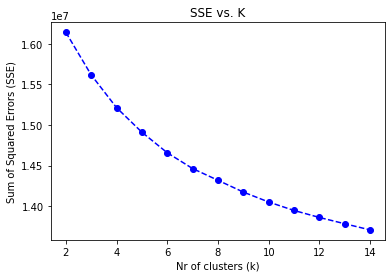

In [ ]:
# Plot the change in within-cluster distances across the number of clusters

plt.figure()
plt.plot(range(2, 15, 1), scores, linestyle='--', marker='o', color='b')
plt.xlabel('Nr of clusters (k)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.title('SSE vs. K')
plt.show()

In [ ]:
# We select 7 clusters
kmeans_azdias = KMeans(n_clusters=7, init='k-means++', 
                   random_state=SEED, max_iter=300).fit(azdias_pca)

In [ ]:
azdias_clusters = kmeans_azdias.predict(azdias_pca)
customers_clusters = kmeans_azdias.predict(customers_pca)

### We now **compare** the demographic data (*azdias*) and the customer data (*customers_clusters*)

In [ ]:
cluster_general = pd.Series(azdias_clusters).value_counts().sort_index()
cluster_general.index = [1,2,3,4,5,6,7]

In [ ]:
cluster_customers = pd.Series(customers_clusters).value_counts().sort_index()
cluster_customers.index = [1,2,3,4,5,6,7]

In [ ]:
# CHECKPOINT!!! ~~~~~~~~~
#cluster_general.to_csv('/content/drive/My Drive/DATA_SCIENCE/MLEngineer_Nanodegree/data/azdias_clusters.csv', header=True)
#cluster_customers.to_csv('/content/drive/My Drive/DATA_SCIENCE/MLEngineer_Nanodegree/data/customers_clusters.csv', header=True)
#cluster_general = pd.read_csv('/content/drive/My Drive/DATA_SCIENCE/MLEngineer_Nanodegree/data/azdias_clusters.csv',  index_col=False, header=0)
#cluster_customers = pd.read_csv('/content/drive/My Drive/DATA_SCIENCE/MLEngineer_Nanodegree/data/customers_clusters.csv', index_col=False, header = 0)

In [ ]:
prop_general = []
for value in cluster_general:
    prop = (value / len(azdias_clusters))*100
    prop_general.append(prop)

prop_cluster_general = pd.Series(prop_general)
prop_cluster_general.index = [1,2,3,4,5,6,7]
# --------------------------------------------------
prop_customers = []
for value in cluster_customers:
    prop = (value / len(customers_clusters))*100
    prop_customers.append(prop)

prop_cluster_customers = pd.Series(prop_customers)
prop_cluster_customers.index = [1,2,3,4,5,6,7]

Text(0, 0.5, '%')

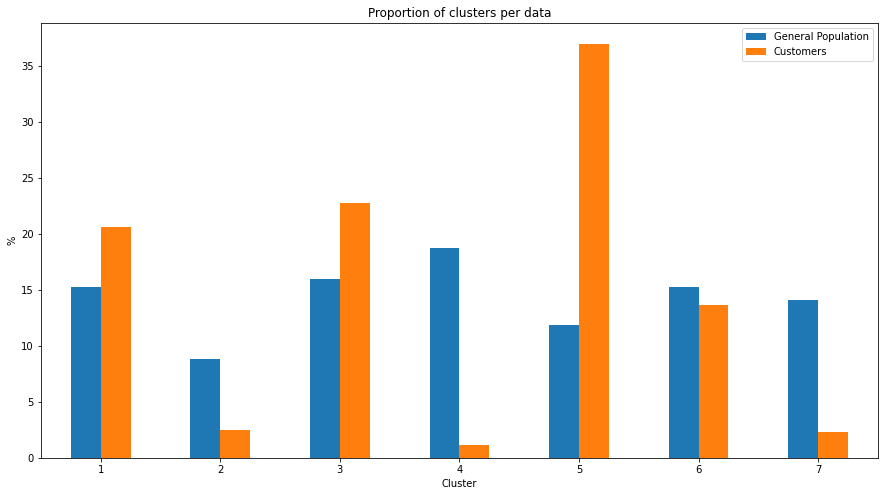

In [ ]:
# Compare the proportion of data in each cluster for the general population
# and the customers

prop = pd.DataFrame({'General Population': prop_cluster_general,
                     'Customers': prop_cluster_customers})
ax = prop.plot.bar(rot=0, figsize=(15, 8), title = 'Proportion of clusters per data')
ax.set_xlabel('Cluster')
ax.set_ylabel('%')

We can produce again the original values (undoing the scaling and the PCA), to check what characterizes the clusters where customers are in a larger proportion (i.e. 1, 3 and 5):

In [ ]:
# Cluster 1
over1 = scaler.inverse_transform(my_pca.inverse_transform(customers_pca[np.where(customers_clusters==0)])).round()
df_over1 = pd.DataFrame(data=over1, columns=customers.columns)
df_over1.head()

,Unnamed: 0,LNR,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,...,PLZ8_HHZ,PRAEGENDE_JUGENDJAHRE,RELAT_AB,RETOURTYP_BK_S,RT_KEIN_ANREIZ,RT_SCHNAEPPCHEN,RT_UEBERGROESSE,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,SOHO_KZ,STRUKTURTYP,UMFELD_ALT,UMFELD_JUNG,UNGLEICHENN_FLAG,VERDICHTUNGSRAUM,VERS_TYP,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,-5962.0,429799.0,1.0,8.0,5.0,0.0,-0.0,1.0,5.0,0.0,2.0,7.0,5.0,2.0,5.0,1.0,1.0,6.0,4.0,5.0,5.0,0.0,-0.0,0.0,0.0,1.0,-0.0,-0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,3.0,2.0,...,3.0,3.0,1.0,3.0,1.0,5.0,2.0,3.0,4.0,5.0,2.0,3.0,5.0,5.0,4.0,3.0,3.0,4.0,6.0,3.0,6.0,0.0,0.0,1.0,3.0,4.0,-0.0,2.0,1.0,1.0,2.0,6.0,6.0,4.0,6.0,8.0,6.0,1.0,1.0,3.0
1,-8010.0,376190.0,1.0,10.0,-2.0,-0.0,-0.0,2.0,-1.0,0.0,2.0,6.0,4.0,2.0,5.0,2.0,1.0,5.0,5.0,5.0,5.0,-0.0,0.0,0.0,0.0,6.0,6.0,5.0,2.0,-0.0,1.0,4.0,0.0,0.0,1.0,6.0,6.0,-0.0,2.0,2.0,...,5.0,6.0,2.0,5.0,3.0,5.0,4.0,2.0,3.0,4.0,2.0,3.0,5.0,5.0,1.0,3.0,3.0,4.0,4.0,3.0,6.0,-0.0,0.0,1.0,4.0,5.0,0.0,1.0,1.0,0.0,4.0,4.0,4.0,1.0,6.0,9.0,7.0,1.0,1.0,3.0
2,-7048.0,384229.0,1.0,12.0,-3.0,0.0,-0.0,1.0,-3.0,0.0,2.0,6.0,3.0,3.0,3.0,1.0,1.0,5.0,5.0,5.0,5.0,0.0,-0.0,0.0,1.0,-1.0,3.0,4.0,1.0,1.0,0.0,-0.0,2.0,3.0,1.0,0.0,2.0,2.0,1.0,-0.0,...,3.0,7.0,1.0,5.0,1.0,4.0,3.0,3.0,4.0,5.0,2.0,2.0,5.0,7.0,6.0,3.0,3.0,5.0,6.0,4.0,7.0,-0.0,0.0,2.0,2.0,5.0,0.0,7.0,1.0,1.0,3.0,3.0,4.0,3.0,6.0,3.0,3.0,1.0,1.0,3.0
3,-9435.0,380249.0,1.0,15.0,-2.0,-0.0,0.0,1.0,-2.0,-0.0,4.0,6.0,4.0,4.0,1.0,3.0,2.0,3.0,3.0,4.0,4.0,-0.0,-0.0,-0.0,0.0,1.0,6.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,3.0,2.0,...,3.0,9.0,5.0,2.0,3.0,3.0,3.0,6.0,7.0,1.0,6.0,6.0,1.0,7.0,1.0,1.0,2.0,1.0,1.0,1.0,3.0,3.0,0.0,3.0,3.0,4.0,0.0,13.0,2.0,1.0,4.0,6.0,8.0,7.0,6.0,7.0,4.0,3.0,2.0,4.0
4,-8434.0,325415.0,1.0,8.0,-1.0,-0.0,-0.0,2.0,-1.0,0.0,1.0,6.0,2.0,2.0,4.0,2.0,1.0,5.0,5.0,5.0,4.0,0.0,0.0,1.0,-0.0,-0.0,7.0,-1.0,3.0,6.0,1.0,0.0,2.0,-0.0,2.0,-0.0,6.0,6.0,9.0,8.0,...,4.0,3.0,1.0,2.0,2.0,2.0,2.0,6.0,5.0,3.0,5.0,5.0,4.0,1.0,4.0,5.0,6.0,4.0,4.0,6.0,3.0,3.0,0.0,1.0,4.0,4.0,0.0,4.0,2.0,4.0,1.0,8.0,7.0,4.0,7.0,11.0,7.0,2.0,2.0,2.0


In [ ]:
# Cluster 3
over3 = scaler.inverse_transform(my_pca.inverse_transform(customers_pca[np.where(customers_clusters==2)])).round()
df_over3 = pd.DataFrame(data=over3, columns=customers.columns)
df_over3.head()

,Unnamed: 0,LNR,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,...,PLZ8_HHZ,PRAEGENDE_JUGENDJAHRE,RELAT_AB,RETOURTYP_BK_S,RT_KEIN_ANREIZ,RT_SCHNAEPPCHEN,RT_UEBERGROESSE,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,SOHO_KZ,STRUKTURTYP,UMFELD_ALT,UMFELD_JUNG,UNGLEICHENN_FLAG,VERDICHTUNGSRAUM,VERS_TYP,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,-7239.0,438873.0,1.0,15.0,5.0,0.0,0.0,3.0,4.0,0.0,3.0,3.0,8.0,6.0,3.0,3.0,3.0,4.0,4.0,3.0,4.0,5.0,-0.0,0.0,0.0,1.0,6.0,2.0,1.0,2.0,1.0,4.0,0.0,6.0,1.0,-0.0,7.0,0.0,3.0,3.0,...,3.0,10.0,1.0,5.0,4.0,3.0,5.0,5.0,4.0,5.0,3.0,2.0,5.0,6.0,6.0,4.0,4.0,5.0,4.0,4.0,5.0,1.0,0.0,3.0,2.0,4.0,-0.0,-0.0,2.0,1.0,4.0,4.0,5.0,5.0,2.0,8.0,3.0,1.0,1.0,3.0
1,-6977.0,338409.0,1.0,14.0,1.0,-0.0,0.0,3.0,1.0,-0.0,1.0,6.0,5.0,5.0,4.0,2.0,2.0,5.0,4.0,5.0,5.0,-0.0,0.0,0.0,5.0,1.0,6.0,-1.0,0.0,6.0,0.0,-0.0,1.0,0.0,1.0,-0.0,6.0,6.0,2.0,2.0,...,4.0,8.0,1.0,3.0,4.0,4.0,5.0,2.0,4.0,5.0,2.0,3.0,5.0,5.0,4.0,2.0,3.0,3.0,6.0,2.0,6.0,0.0,0.0,1.0,5.0,4.0,-0.0,-1.0,1.0,0.0,3.0,5.0,7.0,6.0,4.0,9.0,7.0,1.0,1.0,4.0
2,-5975.0,322598.0,7.0,18.0,-0.0,-0.0,0.0,4.0,-0.0,0.0,1.0,3.0,2.0,5.0,3.0,5.0,4.0,2.0,2.0,2.0,3.0,3.0,0.0,1.0,2.0,6.0,5.0,2.0,3.0,6.0,1.0,3.0,1.0,6.0,1.0,6.0,5.0,7.0,1.0,2.0,...,5.0,14.0,1.0,4.0,4.0,4.0,4.0,3.0,4.0,4.0,3.0,3.0,5.0,6.0,2.0,4.0,2.0,3.0,6.0,2.0,7.0,3.0,0.0,3.0,4.0,4.0,-0.0,3.0,1.0,1.0,3.0,2.0,2.0,0.0,3.0,10.0,4.0,1.0,1.0,3.0
3,-4278.0,263173.0,1.0,11.0,-0.0,0.0,0.0,3.0,-0.0,0.0,2.0,7.0,6.0,2.0,4.0,2.0,1.0,5.0,5.0,5.0,5.0,6.0,0.0,0.0,0.0,-0.0,-0.0,-1.0,1.0,6.0,0.0,1.0,1.0,-0.0,1.0,0.0,3.0,6.0,4.0,3.0,...,3.0,4.0,3.0,3.0,2.0,5.0,2.0,5.0,8.0,3.0,6.0,6.0,2.0,7.0,2.0,2.0,3.0,1.0,5.0,2.0,4.0,3.0,0.0,3.0,5.0,5.0,0.0,21.0,1.0,4.0,2.0,2.0,2.0,1.0,2.0,10.0,3.0,3.0,2.0,4.0
4,-10437.0,420204.0,1.0,15.0,0.0,0.0,1.0,3.0,1.0,0.0,1.0,6.0,4.0,3.0,2.0,3.0,2.0,5.0,4.0,5.0,3.0,7.0,-0.0,1.0,-1.0,6.0,6.0,2.0,4.0,6.0,2.0,7.0,2.0,1.0,2.0,6.0,7.0,7.0,4.0,4.0,...,3.0,10.0,1.0,3.0,2.0,1.0,3.0,6.0,6.0,3.0,5.0,5.0,3.0,1.0,3.0,4.0,4.0,2.0,5.0,4.0,3.0,3.0,0.0,1.0,3.0,5.0,0.0,2.0,1.0,1.0,1.0,3.0,5.0,5.0,1.0,7.0,7.0,1.0,2.0,3.0


In [ ]:
# Cluster 5
over5 = scaler.inverse_transform(my_pca.inverse_transform(customers_pca[np.where(customers_clusters==4)])).round()
df_over5 = pd.DataFrame(data=over5, columns=customers.columns)
df_over5.head()

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [28]:
mailout_train = pd.read_csv('/content/drive/My Drive/DATA_SCIENCE/MLEngineer_Nanodegree/data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
mailout_train.head()

Our target is the variable *RESPONSE*. We can see that it is highly unbalanced:

0    42430
1      532
Name: RESPONSE, dtype: int64


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


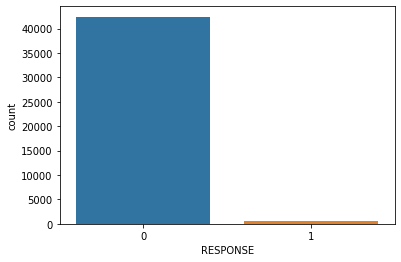

In [36]:
print(mailout_train.RESPONSE.value_counts())
sns.countplot('RESPONSE', data=mailout_train)

### We create a function to apply the same cleaning process as applied to the general and the customer populations.

In [39]:
def clean_data(df):
  """ Clean the data as done for the population and customers """

  # Convert unknown values into missing data
  df = missing_to_nan(df, feat_info_unknown)

  # Drop columns where more than 30% of customers/population rows were missing
  df = df.drop(remove_cols, axis=1)

  # Drop rows with more than 50 missing features (even with risk of removing targets)
  miss_rows = df.isnull().sum(axis=1)
  df = df[miss_rows < 50].reset_index(drop=True)

  # Drop additional columns
  remove_cols2 = ['EINGEFUEGT_AM', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015', 'D19_LETZTER_KAUF_BRANCHE']
  df = df.drop(remove_cols2, axis=1)

  # Encode
  df['OST_WEST_KZ'] = df['OST_WEST_KZ'].replace({'W': 0, 'O': 1})
  df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].replace({'X': np.nan}).astype(float)

  return df

In [61]:
mailout_train_clean = clean_data(mailout_train)

In [62]:
print(mailout_train.shape, mailout_train_clean.shape)

(42962, 367) (33837, 321)


In [63]:
# Drop LNR, the ID variable
mailout_train_clean.drop('LNR', axis=1, inplace=True)

In [64]:
# Imputing Missing data --> We impute also the target, because there are some NaN
imputer = SimpleImputer(strategy='most_frequent')
imputed_mailout = pd.DataFrame(imputer.fit_transform(mailout_train_clean), columns = mailout_train_clean.columns)

In [70]:
# Split data to features and target
target = imputed_mailout['RESPONSE']
print(target.nunique())

# Now drop RESPONSE variable
features = imputed_mailout.drop('RESPONSE', axis=1)

2


In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import plot_roc_curve
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

### Train-test split: 80-20.
With stratify to have the same proportion of target values in the train and test. Also shuffle in case the dataset is in a predefined order.

In [71]:
X_train, X_test, y_train, y_test = train_test_split(features, target, train_size=0.8,
                                                    stratify = target,
                                                    random_state=SEED, shuffle=True)

### **Benchmark**: We will establish a benchmark model. This is a classification problem, so a simple algorithm would be a Logistic Regression with default hyperparameters and nothing else.

Note that the algorithms we will test do not need scaling.

In [72]:
lr = LogisticRegression(random_state=SEED)

In [ ]:
lr.fit(X_train, y_train)

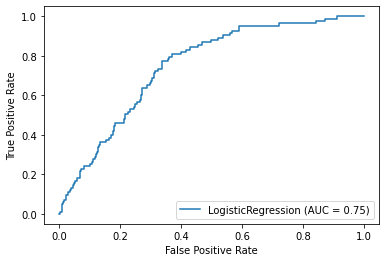

In [80]:
lr_disp = plot_roc_curve(lr, X_test, y_test)

The AUC for Logistic Regression is 0.75. We will try to improve that.

As the class 1 (people that become customers) is very small compared to class 0, we have to balance the sample.
First, reducing the majority class:

In [ ]:
under = RandomUnderSampler(sampling_strategy=0.09, random_state=SEED)
X_rus, y_rus = under.fit_resample(X_train, y_train)
print(Counter(y_rus))

In [ ]:
over = RandomOverSampler(sampling_strategy=1, random_state=SEED)
X_combined_sampling, y_combined_sampling = over.fit_resample(X_rus, y_rus)

Although the sample has been reduced, we have a better representation of class 1. This will help the models.

In [100]:
print(Counter(y_combined_sampling))

Counter({0.0: 3700, 1.0: 3700})


We will make a k-fold cross validation, to get more robust estimate of the quality of our models:

In [101]:
kfold = StratifiedKFold(n_splits=5, random_state=SEED, shuffle=True)

### Now let's try 3 different tree-based models:

1. Random Forest
2. Ada Boosting
3. Extra Trees

We will use a search grid to choose between few options of parameters for the 3 models. This will not be exhaustive though.

In [103]:
rf = RandomForestClassifier()
ab = AdaBoostClassifier(DecisionTreeClassifier(random_state=3, max_depth=6))
xt = ExtraTreesClassifier()

# Random Forests:
grid_search_rf = {'max_depth': [6, 8],
                  'min_samples_split': [2, 3],
                  'min_samples_leaf': [1, 3],
                  'criterion': ['gini'],
                  'bootstrap': [False],
                  'n_estimators' :[200, 300],
                  'random_state': [3]}
# Ada Boost:
grid_search_ab = {'n_estimators': [200, 300],
                  'learning_rate': [0.0001, 0.001]}

# Extra Trees
grid_search_xt = {'n_estimators': [200, 300],
                  'criterion': ['gini'],
                  'bootstrap': [False],
                  'max_depth': [6, 8],
                  'min_samples_split': [2, 3],
                  'min_samples_leaf': [1, 3]}

rf_gs = GridSearchCV(rf, param_grid = grid_search_rf, cv=kfold, scoring='roc_auc',
                     n_jobs= -1, verbose = 1)

ab_gs = GridSearchCV(ab, param_grid = grid_search_ab, cv=kfold, scoring='roc_auc',
                     n_jobs= -1, verbose = 1)

xt_gs = GridSearchCV(xt, param_grid = grid_search_xt, cv=kfold, scoring='roc_auc',
                     n_jobs= -1, verbose = 1)

### Random Forest:

In [104]:
rf_gs.fit(X_combined_sampling, y_combined_sampling)
from joblib import dump
rf_best = rf_gs.best_estimator_
dump(rf_best, '/content/drive/My Drive/DATA_SCIENCE/MLEngineer_Nanodegree/data/random_forest.joblib')

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   52.5s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  1.8min finished


['/content/drive/My Drive/DATA_SCIENCE/MLEngineer_Nanodegree/data/random_forest.joblib']

### Ada Boosting:

In [105]:
ab_gs.fit(X_combined_sampling, y_combined_sampling)
ab_best = ab_gs.best_estimator_
dump(ab_best, '/content/drive/My Drive/DATA_SCIENCE/MLEngineer_Nanodegree/data/adaboost4.joblib')

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  7.0min finished


['/content/drive/My Drive/DATA_SCIENCE/MLEngineer_Nanodegree/data/adaboost4.joblib']

### Extra Trees:

In [106]:
xt_gs.fit(X_combined_sampling, y_combined_sampling)
xt_best = xt_gs.best_estimator_
dump(xt_best, '/content/drive/My Drive/DATA_SCIENCE/MLEngineer_Nanodegree/extratrees.joblib')

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   33.5s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  1.1min finished


['/content/drive/My Drive/DATA_SCIENCE/MLEngineer_Nanodegree/extratrees.joblib']

### Let's test the 3 models, to choose the final one for the Kaggle competition

The Area Under Curve (AUC) is a good score to evaluate classification problems, and it informs about how well the model is able to distinguish between classes. It is better the closer to 1 it is, with 0.5 representing the boundary of 50% chance.

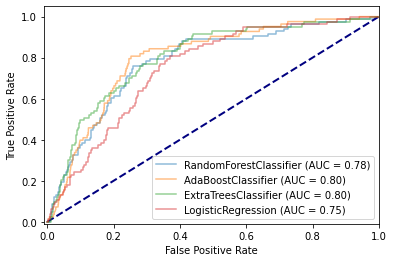

In [110]:
rf_disp = plot_roc_curve(rf_best, X_test, y_test, alpha=0.5)
ax = plt.gca()
ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax.set(xlim=[-0.01, 1.0], ylim=[-0.01, 1.05])
ab_disp = plot_roc_curve(ab_best, X_test, y_test, ax=ax, alpha=0.5)
xt_disp = plot_roc_curve(xt_best, X_test, y_test, ax=ax, alpha=0.5)
lr_disp = plot_roc_curve(lr, X_test, y_test, ax=ax, alpha=0.5)
plt.show()

We can see that the 3 models outperform the benchmark logistic regression, with the Ada Boosting and the Extra Trees giving similar AUC values. We will choose the **Extra Trees** model, since it took only 1 minute to run, and it could be faster for future parameter tuning.

### Model improvements:

- More exhaustive grid search for hyper-parameter tuning.

- Tuning with Feature Selection. More features does not always mean better model, and sometimes selecting the adequate features we can obtain a more generalized model.

- Test more models.

- A more in-deep pre-processing (remove possible outliers, other scaling methods...)

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [144]:
mailout_test = pd.read_csv('/content/drive/My Drive/DATA_SCIENCE/MLEngineer_Nanodegree/data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


The submission must have the same number of rows as the original test dataset, so we can't remove rows with a large amount of missing features as before.

In [142]:
def clean_test_data(df):
  """ Clean the data as done for the population and customers """

  # Convert unknown values into missing data
  df = missing_to_nan(df, feat_info_unknown)

  # Drop columns where more than 30% of customers/population rows were missing
  df = df.drop(remove_cols, axis=1)

  # Drop additional columns
  remove_cols2 = ['EINGEFUEGT_AM', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015', 'D19_LETZTER_KAUF_BRANCHE']
  df = df.drop(remove_cols2, axis=1)

  # Encode
  df['OST_WEST_KZ'] = df['OST_WEST_KZ'].replace({'W': 0, 'O': 1})
  df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].replace({'X': np.nan}).astype(float)

  return df

In [145]:
mailout_test_clean = clean_test_data(mailout_test)

In [146]:
mailout_test_LNR = mailout_test_clean['LNR']
mailout_test_clean.drop('LNR', axis=1, inplace=True)

In [147]:
# Imputing Missing data
imputer = SimpleImputer(strategy='most_frequent')
imputed_mailout_test = pd.DataFrame(imputer.fit_transform(mailout_test_clean),
                                    columns = mailout_test_clean.columns)

In [148]:
pred_test = xt_best.predict(imputed_mailout_test)

In [149]:
df_sub = pd.DataFrame({'LNR': mailout_test_LNR, 'RESPONSE': pred_test})

In [151]:
df_sub.to_csv('/content/drive/My Drive/DATA_SCIENCE/MLEngineer_Nanodegree/data/submission_kaggle.csv', index=False)

Submission done!

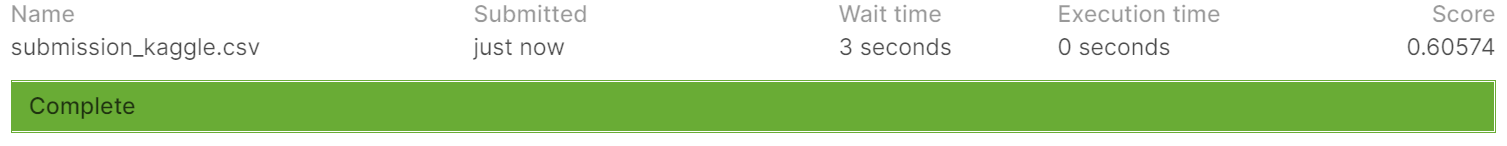

In [157]:
from IPython.display import Image
Image(filename = '/content/drive/My Drive/DATA_SCIENCE/MLEngineer_Nanodegree/data/submission.png',
      width = 1000, height = 110)



---

